# Climate Analysis and Exploration

In [1]:
# setup dependencies
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Create Database Connection
# ----------------------------------
#  Establish SQL Lite connection
DB_CONN_URI_DEFAULT = 'sqlite:///hawaii.sqlite'

engine = create_engine(DB_CONN_URI_DEFAULT)
conn = engine.connect()

In [3]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [4]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [5]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['HONOLULU',
 'KANEOHE',
 'KUALOA',
 'MANOA',
 'PEARL',
 'UPPER',
 'WAIHEE',
 'WAIKIKI',
 'WAIMANALO',
 'measurements',
 'stations']

In [6]:
# Assign the measurements and stations class to a variable
Measurement = Base.classes.measurements # Create a session
Station = Base.classes.stations

In [7]:
# Create a session
session = Session(engine)

In [8]:
# Display the row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20057649f28>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

In [9]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x200576c8588>,
 'date': datetime.date(2010, 1, 1),
 'measurement_id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}

## Precipation Analysis

In [10]:
import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.ticker import MaxNLocator

end_date = datetime.datetime.strptime('06/01/2017','%m/%d/%Y')
start_date = end_date - relativedelta(months=12)

In [11]:
# query = session.query(Measurement.station, Measurement.prcp).\
#    filter(.station == 'USC00519397')

query = session.query(Station, Measurement).\
    join(Measurement, (
        Station.station == Measurement.station)).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    order_by(Measurement.date).\
    all()

In [12]:
def autolabel(rect):
    h = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
            ha='center', va='bottom', fontsize=12,rotation=90,fontweight='bold')

def plotClimate(query, table):
    # create a dataframe
    w_df = pd.DataFrame(query)
    w_df.set_index('date',inplace=True)
    w_df.sort_index(inplace=True)
    
    # setup tick values
    dates = w_df.index.values
    step_up = round(len(dates)/10, 0)    
    xdateticks = np.arange(0,len(dates),int(step_up))   
    xticklabels = np.array([dates[x] for x in xdateticks]) 
    
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    rect = ax.bar(np.arange(0, len(dates)), w_df['prcp'],width=1, linewidth=2, align='center', label="precipitation")

    # assign tick values
    ax.set_xticks(xdateticks) 
    ax.set_xticklabels(xticklabels, rotation=45)
    
    # assign y limits so all graphs have the same y limits for comparison
    ax.set_ylim(0, 10, 2)
    
    # set up title and xlabel
    ax.set_xlabel("Date", fontsize=9)
    title = ax.set_title("%s: Climate Precipation" % t.title(), fontsize=15)
    title.set_position([.5, 1.05])
    
    # plot
    plt.legend(loc="best")
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig("%s_Climate_Precipation.png" % t )


No data found


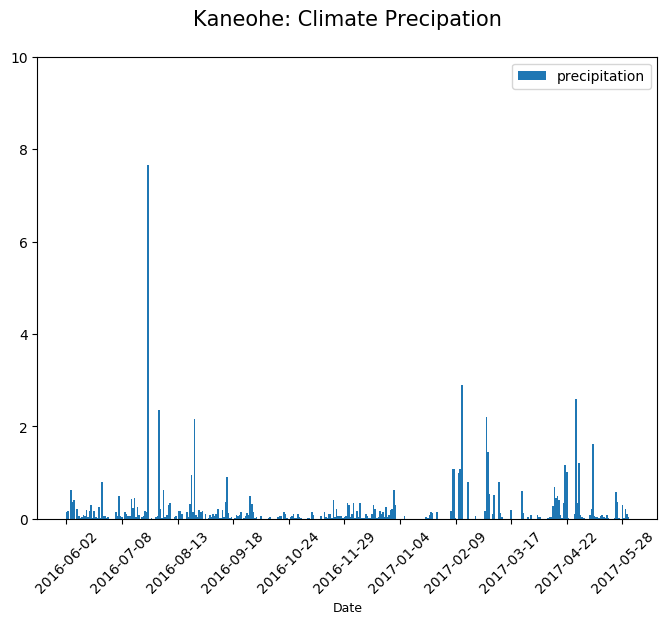

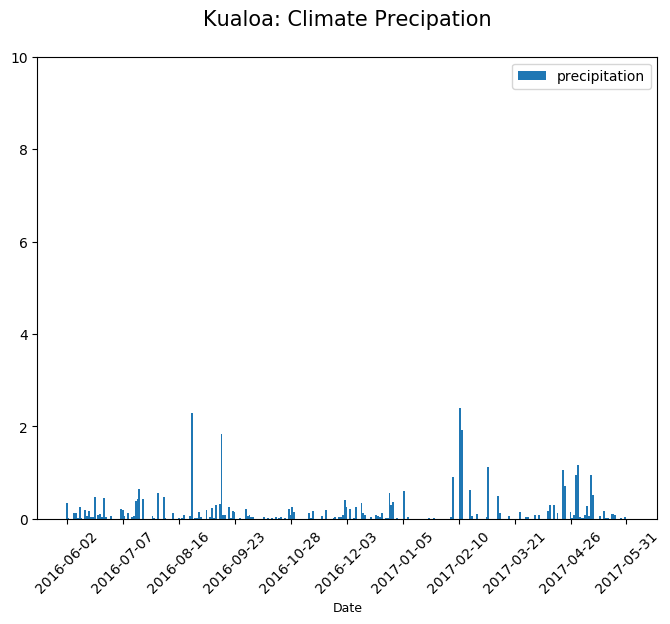

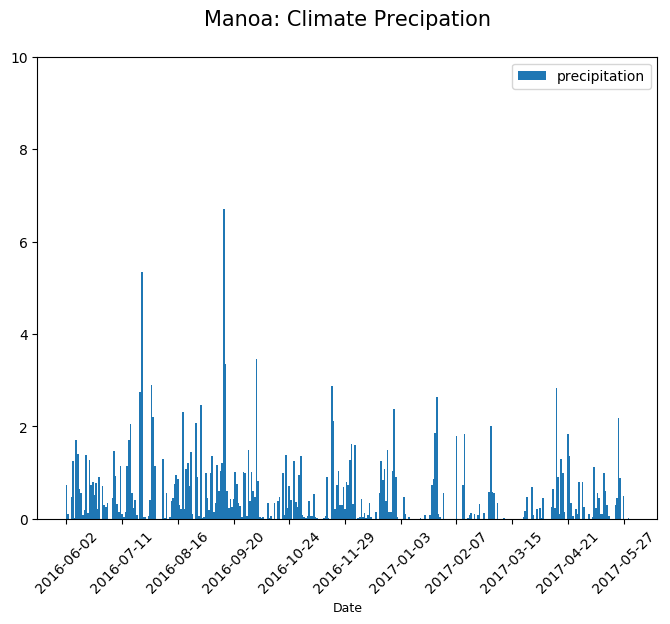

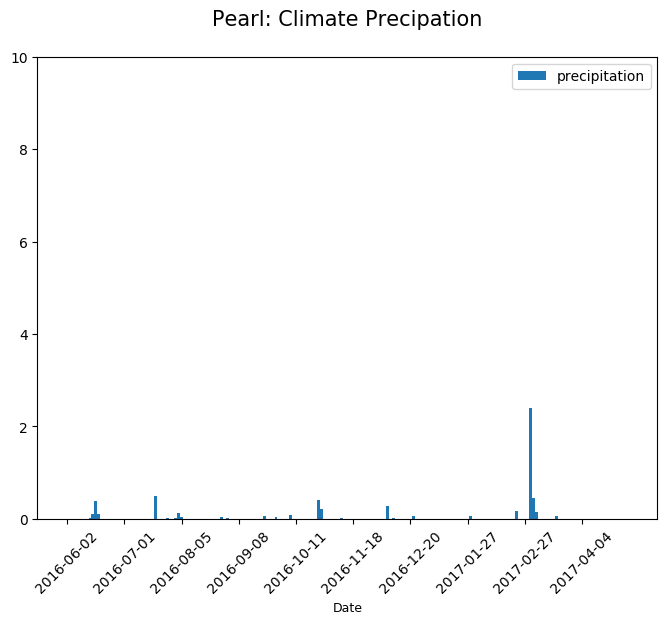

No data found


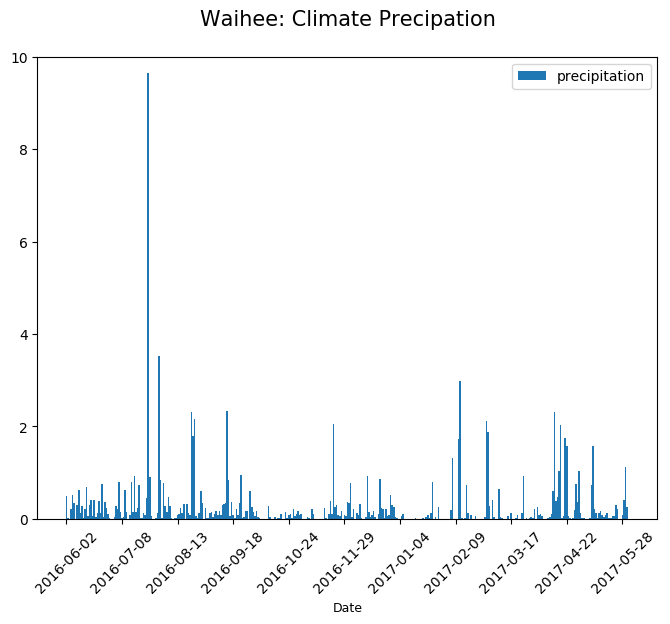

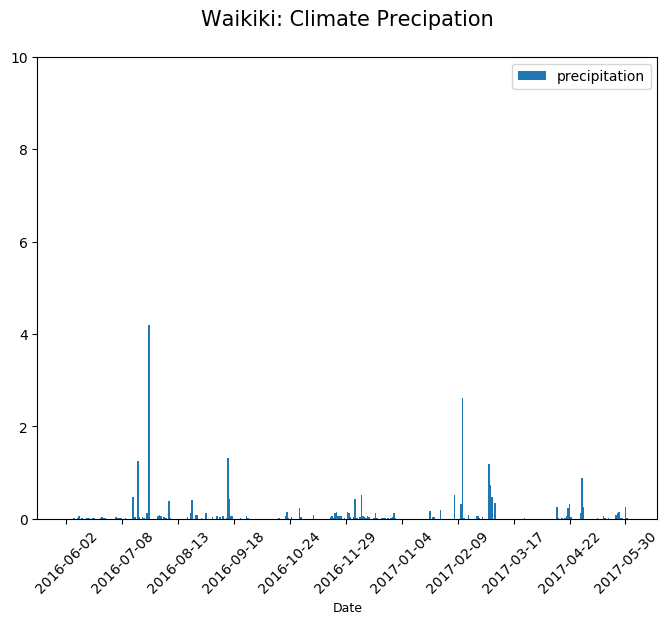

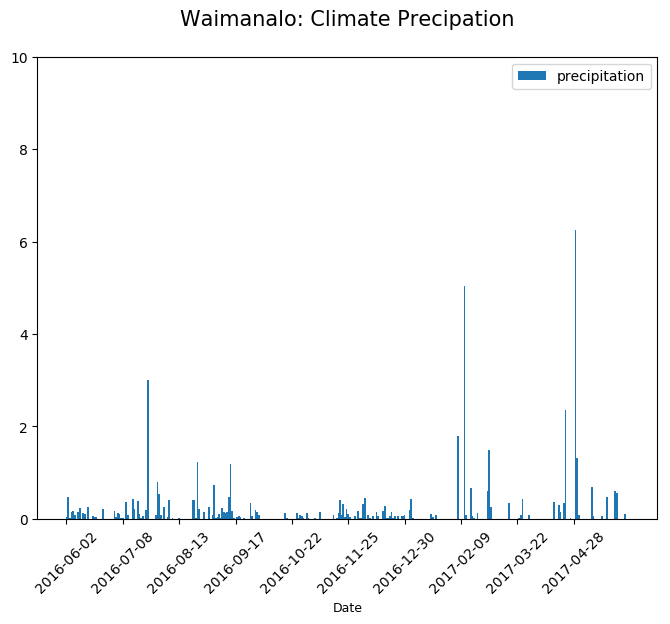

In [13]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

        
        #   plotClimate2(df, t)

for t in Base.classes.keys():
    if t != 'stations' and t != 'measurements':
        table = Base.classes[t]

        query = session.query(table.date, table.prcp).\
            filter(table.date >= start_date).filter(table.date <= end_date).\
            order_by(table.date)

        df = pd.read_sql_query(query.statement, session.bind, index_col='date')        
        df.index = pd.to_datetime(df.index)
            
           

        if query.count() > 0:            
            plotClimate(query.all(), t)

        #   plotClimate2(query.all(), t)
           
           
        else:
            print("No data found")
        

## Station Analysis

In [14]:
from sqlalchemy import func, extract

In [15]:
# Query to find total number of stations
query = session.query(Station.station).count()
    
print('Total Number of stations: %s' % query)

Total Number of stations: 9


In [16]:
# List the stations and observation counts in descending order
query = session.query(Station.name, func.count(Measurement.date).label('total')).\
    join(Measurement, (Station.station == Measurement.station)).\
    group_by(Measurement.station).order_by('total DESC')

print("Counts\t Station Name") 
for q in query:
    print("%s:\t %s" % (q[1], q[0]))

#WHich station has the highest number of observations
print("")    
print('%s has the highest number of observation' % query.first()[0])

Counts	 Station Name
2772:	 WAIHEE 837.5, HI US
2724:	 WAIKIKI 717.2, HI US
2709:	 KANEOHE 838.1, HI US
2669:	 WAIMANALO EXPERIMENTAL FARM, HI US
2612:	 MANOA LYON ARBO 785.2, HI US
2202:	 KUALOA RANCH HEADQUARTERS 886.9, HI US
1979:	 HONOLULU OBSERVATORY 702.2, HI US
1372:	 PEARL CITY, HI US
511:	 UPPER WAHIAWA 874.3, HI US

WAIHEE 837.5, HI US has the highest number of observation


C:\Users\lizet\Anaconda3\envs\PythonData\lib\site-packages\sqlalchemy\sql\compiler.py:624: SAWarning: Can't resolve label reference 'total DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


In [17]:
# Query to retrieve the last 12 months of temperature
# get the most recent date
query_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()  
    
end_date = query_date[0]
start_date = end_date - relativedelta(months=12)

query_tobs = session.query(Measurement.station, func.count(Measurement.tobs).label('total')).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    group_by(Measurement.station).\
    order_by('total DESC').first()
print("%s has the highest number of temperature observations between %s and %s " % (query_tobs[0], start_date, end_date))    

USC00519397 has the highest number of temperature observations between 2016-08-23 and 2017-08-23 


C:\Users\lizet\Anaconda3\envs\PythonData\lib\site-packages\sqlalchemy\sql\compiler.py:624: SAWarning: Can't resolve label reference 'total DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


In [18]:
# Filter by the station with the highest number of observations 
query_df = pd.read_sql(session.query(Measurement.tobs).\
    filter(Measurement.station == query_tobs[0]).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).statement, session.bind)

query_df.head()

,tobs
0,81
1,79
2,80
3,79
4,77


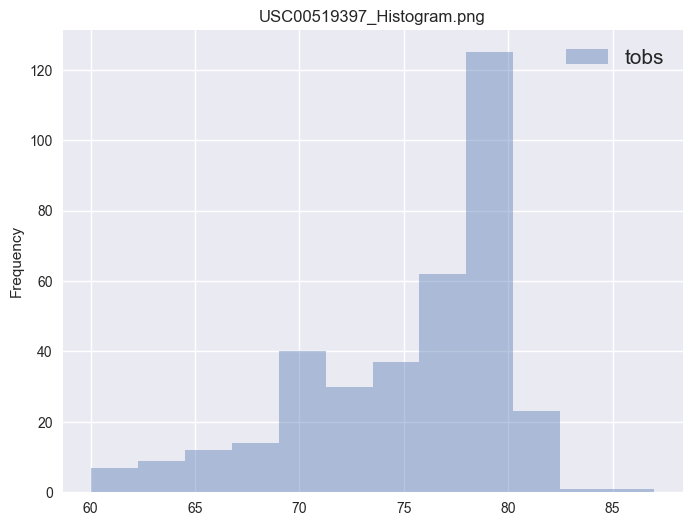

In [19]:
# Plot the results as a histogram
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.grid(True)

sns.distplot(query_df['tobs'], bins=12, kde=False, label='tobs');
plt.ylabel('Frequency')
plt.xlabel('')
plt.title("%s_Histogram.png" % query_tobs[0])

plt.legend(loc="best", fontsize=15)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("%s_Histogram.png" % query_tobs[0])

## Temperature Analysis

In [20]:
def calc_temps(enddate):
    try:
        datetime.datetime.strptime(enddate, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect enddate format, should be YYYY-MM-DD")
        
    datetime_object = datetime.datetime.strptime(enddate, '%Y-%m-%d')
    startdate = datetime_object - relativedelta(months=12)

        
    minimum = session.query(func.min(Measurement.tobs)).\
        filter(Measurement.date >= startdate).filter(Measurement.date <= enddate).scalar()
       
    maximum = session.query(func.max(Measurement.tobs)).\
        filter(Measurement.date >= startdate).filter(Measurement.date <= enddate).scalar()
    
    average = session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.date >= startdate).filter(Measurement.date <= enddate).scalar()
    
    return {"minimum": minimum, "average": average, "maximum": maximum}

56   73.16255778120185   85


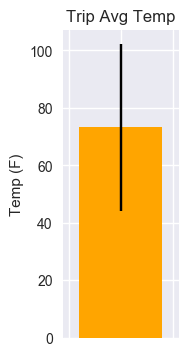

In [21]:
# Use calc_temp to calculate min, avg, max temperature for your trip using matching dates from previous year
temp_obs = calc_temps('2015-02-01')
print("%s   %s   %s" % (temp_obs['minimum'], temp_obs['average'], temp_obs['maximum'])) 

# Plot min, avg, and max temprature
fig = plt.figure(figsize=(1.5,4))
ax = plt.subplot(111)
ax.yaxis.grid(True)

plt.margins(x=.2)

p1 = plt.bar(1, temp_obs['average'], color='orange',  yerr=temp_obs['maximum']-temp_obs['minimum'], align='center')

plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off


fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("Trip Average Temp.png")

## Rainfall Analysis

In [22]:
def daily_normals(enddate):
    try:
        datetime.datetime.strptime(enddate, '%m-%d')
    except ValueError:
        raise ValueError("Incorrect date format, should be MM-DD") 
        
    datetime_object = datetime.datetime.strptime(enddate, '%m-%d')

    minimum = session.query(func.min(Measurement.tobs)).\
        filter(extract('month', Measurement.date) == datetime_object.month).filter(extract('day', Measurement.date) == datetime_object.day).scalar()
       
    maximum = session.query(func.max(Measurement.tobs)).\
        filter(extract('month', Measurement.date) == datetime_object.month).filter(extract('day', Measurement.date) == datetime_object.day).scalar()
    
    average = session.query(func.avg(Measurement.tobs)).\
        filter(extract('month', Measurement.date) == datetime_object.month).filter(extract('day', Measurement.date) == datetime_object.day).scalar()
        
    return {"minimum": minimum, "average": average, "maximum": maximum}

In [23]:
trip_date_list = ['07-22','07-23','07-24','07-25','07-25','07-26','07-27']

maximum_list = []
minimum_list = []
average_list = []
date_list = []

for d in trip_date_list:
    x = daily_normals(d)
    date = datetime.datetime.strptime(d, '%m-%d')
    newdate = '2018-%s-%s' % (date.month, date.day)
    date_list.append(newdate)
    minimum_list.append(x['minimum'])
    average_list.append(x['average'])
    maximum_list.append(x['maximum'])
    
rainfall_df = pd.DataFrame({
    'date': date_list,
    'tmin': minimum_list,
    'tavg': average_list,
    'tmax': maximum_list
})

rainfall_df = rainfall_df.convert_objects(convert_numeric=True)
rainfall_df.set_index('date', inplace=True)
print(rainfall_df['tavg'])

date
2018-7-22    75.788462
2018-7-23    76.203704
2018-7-24    76.555556
2018-7-25    76.890909
2018-7-25    76.890909
2018-7-26    76.442308
2018-7-27    76.581818
Name: tavg, dtype: float64


C:\Users\lizet\Anaconda3\envs\PythonData\lib\site-packages\ipykernel\__main__.py:24: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


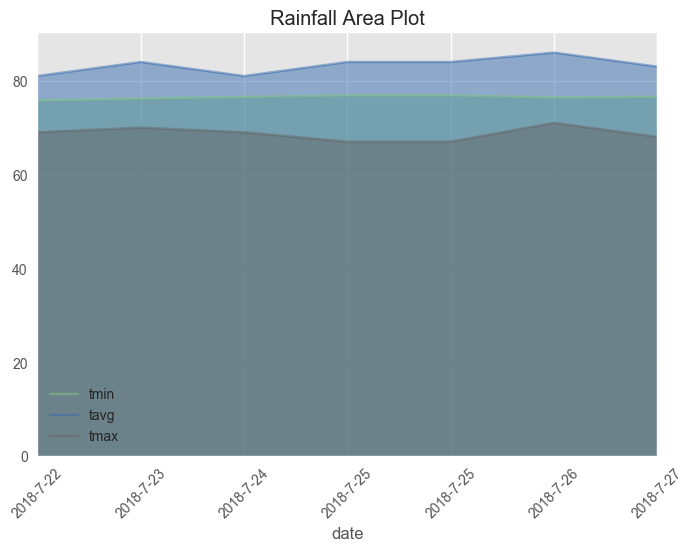

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime as dt
mpl.style.use('ggplot')


x = np.arange(len(rainfall_df.index))
# Plot
rainfall_df.plot(kind='area', stacked=False, alpha=0.5, colormap='Accent',
        title='Rainfall Area Plot')

# assign tick values
plt.xticks(x, date_list, rotation=45)

# create legend
[ax.legend(('tmin', 'tavg', 'tmax'),
           loc='lower left') for ax in plt.gcf().axes]
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("Rainfall Area Plot.png")